# Plan:

- Load the data
- Visualise
- Preprocess
- Dataset definition
- Model definition
- Model training
- Model testing
- Results analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler , LabelEncoder

from torch.utils.data import DataLoader , Dataset
from transformers import BertTokenizer , BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random as rn

# set the seed
# seed = 11
# np.random.seed(seed)
# torch.manual_seed(seed)

np.random.seed(17)
rn.seed(12345)

c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Load the data

In [2]:
train_path = "data/traindata.csv"
val_path = "data/devdata.csv"

column_names = ['Polarity', 'Aspect', 'TargetTerm', 'Offsets', 'Sentence']

df_train = pd.read_csv(train_path, sep='\t', header=None, names=column_names)
df_val = pd.read_csv(val_path, sep='\t', header=None, names=column_names)

print(df_train.head())

   Polarity              Aspect TargetTerm Offsets  \
0  positive    AMBIENCE#GENERAL    seating   18:25   
1  positive    AMBIENCE#GENERAL  trattoria   25:34   
2  positive        FOOD#QUALITY       food  98:102   
3  negative     SERVICE#GENERAL      STAFF    5:10   
4  positive  FOOD#STYLE_OPTIONS       menu     4:8   

                                            Sentence  
0  short and sweet – seating is great:it's romant...  
1  This quaint and romantic trattoria is at the t...  
2  The have over 100 different beers to offer thi...  
3                        THIS STAFF SHOULD BE FIRED.  
4  The menu looked great, and the waiter was very...  


# Make the datasets

In [3]:
# X_train = df_train.iloc[:, 1:]
# y_train = df_train.iloc[:, 0]
# print(X_train.shape , y_train.shape)

# X_val = df_val.iloc[:, 1:]
# y_val = df_val.iloc[:, 0]
# print(X_val.shape , y_val.shape)

In [4]:
# check the distribution of the target variable
# print(y_train.value_counts(normalize=True))
# print(y_val.value_counts(normalize=True))

print(df_train['Polarity'].value_counts(normalize=True))
print(df_val['Polarity'].value_counts(normalize=True))

Polarity
positive    0.701929
negative    0.259481
neutral     0.038589
Name: proportion, dtype: float64
Polarity
positive    0.702128
negative    0.260638
neutral     0.037234
Name: proportion, dtype: float64


# Data Proprocessing

In [5]:
df_train.head()

,Polarity,Aspect,TargetTerm,Offsets,Sentence
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...
3,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
4,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very..."


In [6]:
import re

# def clean_text(text):
#     """Cleans the input text."""
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-alphabetic characters
#     text = ' '.join(text.split())  # Remove extra spaces
#     return text


# def highlight_target_term(sentence, target_term, offsets):
#     """
#     Inserts special tokens around the target term in the sentence based on offsets.
#     Args:
#     - sentence (str): The sentence from the data.
#     - target_term (str): The target term to be highlighted.
#     - offsets (str): The start and end offsets of the target term in the sentence.
    
#     Returns:
#     - modified_sentence (str): The sentence with the target term highlighted.
#     """
#     start, end = map(int, offsets.split(':'))  # Convert offsets to integer
#     # Insert special tokens around the target term
#     modified_sentence = f"{sentence[:start]} [unused0] {sentence[start:end]} [unused1] {sentence[end:]}"
#     #modified_sentence = modified_sentence.lower()
#     return modified_sentence

def highlight_target_term(sentence, target_term, offsets, crop_chars=40):
    """
    Inserts special tokens around the target term in the sentence based on offsets and crops the sentence.
    
    Args:
    - sentence (str): The sentence from the data.
    - target_term (str): The target term to be highlighted.
    - offsets (str): The start and end offsets of the target term in the sentence.
    - crop_chars (int): The number of characters to include before and after the target term.
    
    Returns:
    - modified_sentence (str): The sentence with the target term highlighted and cropped.
    """
    start, end = map(int, offsets.split(':'))
    # Crop the sentence to a fixed window size around the target term
    cropped_sentence = sentence[max(0, start-crop_chars):min(len(sentence), end+crop_chars)]
    # Insert special tokens around the target term
    highlighted_sentence = (cropped_sentence[:start-max(0, start-crop_chars)] + 
                            " [unused0] " + cropped_sentence[start-max(0, start-crop_chars):end-max(0, start-crop_chars)] + 
                            " [unused1] " + cropped_sentence[end-max(0, start-crop_chars):])
    return highlighted_sentence


# Apply cleaning function to both training and validation datasets
# df_train['Sentence'] = df_train['Sentence'].apply(clean_text)
# df_val['Sentence'] = df_val['Sentence'].apply(clean_text)
df_train['ModifiedSentence'] = df_train.apply(lambda row: highlight_target_term(row['Sentence'], row['TargetTerm'], row['Offsets']), axis=1)
df_val['ModifiedSentence'] = df_val.apply(lambda row: highlight_target_term(row['Sentence'], row['TargetTerm'], row['Offsets']), axis=1)

In [7]:
#df_train.head()
# print the entire ModifiedSentence for the first 5 rows
for i in range(5):
    print(df_train['ModifiedSentence'][i])


short and sweet –  [unused0] seating [unused1]  is great:it's romantic,cozy and private
This quaint and romantic  [unused0] trattoria [unused1]  is at the top of my Manhattan restauran
that made my husband very happy and the  [unused0] food [unused1]  was delicious, if I must recommend a di
THIS  [unused0] STAFF [unused1]  SHOULD BE FIRED.
The  [unused0] menu [unused1]  looked great, and the waiter was very n


In [8]:
# Initialize the LabelEncoder
polarity_encoder = LabelEncoder()

# Fit and transform the training labels, transform the validation labels
df_train['Polarity'] = polarity_encoder.fit_transform(df_train['Polarity'])
df_val['Polarity'] = polarity_encoder.transform(df_val['Polarity'])

c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

In [9]:
df_train.head()

,Polarity,Aspect,TargetTerm,Offsets,Sentence,ModifiedSentence
0,2,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...,short and sweet – [unused0] seating [unused1]...
1,2,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...,This quaint and romantic [unused0] trattoria ...
2,2,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...,that made my husband very happy and the [unus...
3,0,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.,THIS [unused0] STAFF [unused1] SHOULD BE FIRED.
4,2,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very...","The [unused0] menu [unused1] looked great, a..."


In [10]:
# remove the target term and offsets and sentence columns
df_train = df_train.drop(columns=['TargetTerm', 'Offsets', 'Sentence'])
df_val = df_val.drop(columns=['TargetTerm', 'Offsets', 'Sentence'])
df_train.head()

,Polarity,Aspect,ModifiedSentence
0,2,AMBIENCE#GENERAL,short and sweet – [unused0] seating [unused1]...
1,2,AMBIENCE#GENERAL,This quaint and romantic [unused0] trattoria ...
2,2,FOOD#QUALITY,that made my husband very happy and the [unus...
3,0,SERVICE#GENERAL,THIS [unused0] STAFF [unused1] SHOULD BE FIRED.
4,2,FOOD#STYLE_OPTIONS,"The [unused0] menu [unused1] looked great, a..."


In [11]:
df_val.head()

,Polarity,Aspect,ModifiedSentence
0,2,LOCATION#GENERAL,"eat wine list, great service in a great [unus..."
1,0,RESTAURANT#GENERAL,I thought this [unused0] place [unused1] was...
2,2,FOOD#QUALITY,[unused0] Fish [unused1] is so very fresh.
3,0,SERVICE#GENERAL,I showed it to the [unused0] manager [unused1...
4,1,DRINKS#QUALITY,"excellent, although I wouldn't say the [unus..."


---

# Dataset definition

In [12]:
class SentimentDataset(Dataset):
    """
    Dataset class for sentiment analysis with highlighted target terms.
    """
    def __init__(self, modified_sentences, labels, tokenizer, max_len=128):
        self.sentences = modified_sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        modified_sentence = str(self.sentences[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            modified_sentence,
            add_special_tokens=True,  # Adds [CLS] and [SEP]
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Model definition

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, tokenizer):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Resize the token embeddings to accommodate new special tokens
        self.bert.resize_token_embeddings(len(tokenizer))
        self.drop1 = nn.Dropout(p=0.3)  # First dropout layer
        self.fc1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2)  # Fully connected layer
        self.drop2 = nn.Dropout(p=0.2)  # Second dropout layer
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size // 2)  # Layer normalization
        self.out = nn.Linear(self.bert.config.hidden_size // 2, n_classes)  # Final output layer
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.
        
        Args:
            input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
            attention_mask (torch.Tensor): Tensor of attention masks to avoid performing attention on padding token indices.
            
        Returns:
            torch.Tensor: The logits for each input.
        """
        # Pass inputs through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Use the pooled output of BERT
        
        # Pass through the first dropout layer
        dropped_output = self.drop1(pooled_output)
        
        # Pass through the first fully connected layer and apply ReLU activation
        fc1_output = F.relu(self.fc1(dropped_output))
        
        # Pass through the second dropout layer
        dropped_output = self.drop2(fc1_output)
        
        # Apply layer normalization
        norm_output = self.layer_norm(dropped_output)
        
        # Final output layer
        return self.out(norm_output)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens_dict = {'additional_special_tokens': ['[unused0]', '[unused1]']}
tokenizer.add_special_tokens(special_tokens_dict)

batch_size = 8

train_dataset = SentimentDataset(df_train['ModifiedSentence'], df_train['Polarity'], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SentimentDataset(df_val['ModifiedSentence'], df_val['Polarity'], tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# initialize the model and optimizer
n_classes = len(polarity_encoder.classes_)
model = SentimentClassifier(n_classes=n_classes, tokenizer=tokenizer).to(device)
optimizer = Adam(model.parameters(), lr=2e-5)


# define the weights for the loss function
class_proportions = {0: 0.26, 1: 0.04, 2: 0.7}
class_weights = {class_label: (1.0 / proportion) for class_label, proportion in class_proportions.items()}
weight_sum = sum(class_weights.values())
num_classes = len(class_weights)
class_weights = {class_label: (weight / weight_sum) * num_classes for class_label, weight in class_weights.items()}
weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

loss_fn = nn.CrossEntropyLoss(weight=weights_tensor).to(device)

# Train loop

In [16]:
def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels).item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return average_loss, accuracy

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            total_correct += torch.sum(preds == labels).item()

    average_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return average_loss, accuracy


Epoch 1/10 | Train Loss: 0.913 | Train Accuracy: 0.743 | Val Loss: 0.754 | Val Accuracy: 0.816
Epoch 2/10 | Train Loss: 0.641 | Train Accuracy: 0.856 | Val Loss: 0.723 | Val Accuracy: 0.801
Epoch 3/10 | Train Loss: 0.421 | Train Accuracy: 0.893 | Val Loss: 0.805 | Val Accuracy: 0.816
Epoch 4/10 | Train Loss: 0.276 | Train Accuracy: 0.934 | Val Loss: 0.933 | Val Accuracy: 0.838
Epoch 5/10 | Train Loss: 0.164 | Train Accuracy: 0.955 | Val Loss: 1.075 | Val Accuracy: 0.824
Epoch 6/10 | Train Loss: 0.110 | Train Accuracy: 0.970 | Val Loss: 1.201 | Val Accuracy: 0.832
Epoch 7/10 | Train Loss: 0.087 | Train Accuracy: 0.975 | Val Loss: 1.529 | Val Accuracy: 0.838
Epoch 8/10 | Train Loss: 0.071 | Train Accuracy: 0.981 | Val Loss: 1.382 | Val Accuracy: 0.838
Epoch 9/10 | Train Loss: 0.110 | Train Accuracy: 0.968 | Val Loss: 1.507 | Val Accuracy: 0.848
Epoch 10/10 | Train Loss: 0.077 | Train Accuracy: 0.979 | Val Loss: 1.555 | Val Accuracy: 0.859


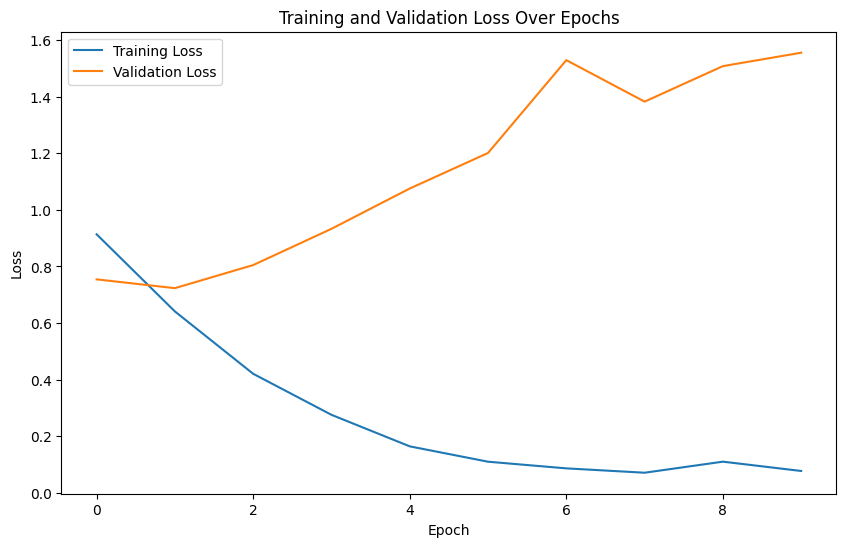

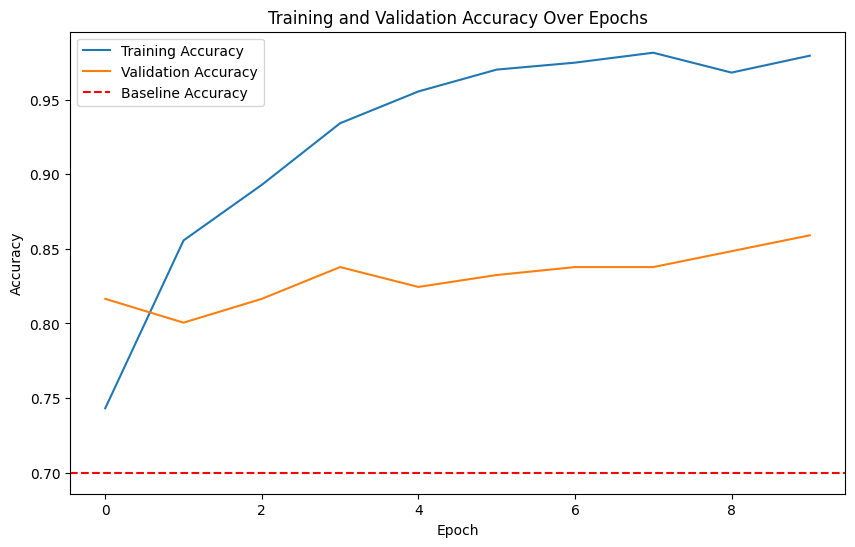

In [17]:
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.3f} | Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy:.3f}')

import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')

plt.axhline(y=0.7, color='r', linestyle='--', label='Baseline Accuracy')

plt.legend()
plt.show()


In [18]:
import torch

def make_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

# Generate predictions and true labels
predictions, true_labels = make_predictions(model, val_loader, device)


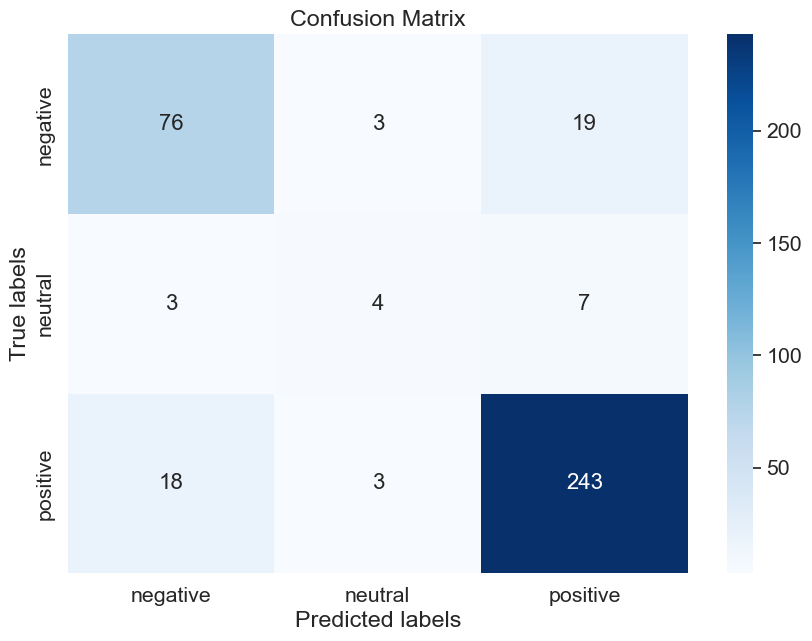

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# print the classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=polarity_encoder.classes_))


              precision    recall  f1-score   support

    negative       0.78      0.78      0.78        98
     neutral       0.40      0.29      0.33        14
    positive       0.90      0.92      0.91       264

    accuracy                           0.86       376
   macro avg       0.70      0.66      0.67       376
weighted avg       0.85      0.86      0.86       376



In [21]:
# print how many of each unique values in predictions and true_labels
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(true_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 97, 1: 10, 2: 269}
{0: 98, 1: 14, 2: 264}


---